前面我们学习了如何在文本序列中表示词元， 并在 14节中训练了词元的表示。 这样的预训练文本表示可以通过不同模型架构，放入不同的下游自然语言处理任务。

前一章我们提及到一些自然语言处理应用，这些应用没有预训练，只是为了解释深度学习架构。 例如，在 8节中， 我们依赖循环神经网络设计语言模型来生成类似中篇小说的文本。 在 9节和 10节中， 我们还设计了基于循环神经网络和注意力机制的机器翻译模型。

然而，本书并不打算全面涵盖所有此类应用。 相反，我们的重点是如何应用深度语言表征学习来解决自然语言处理问题。 在给定预训练的文本表示的情况下， 本章将探讨两种流行且具有代表性的下游自然语言处理任务： 情感分析和自然语言推断，它们分别分析单个文本和文本对之间的关系。

![](https://files.mdnice.com/user/23981/6295de98-47cc-45ab-9476-d2f8f41b5b82.png)

如 图15.1所述， 本章将重点描述然后使用不同类型的深度学习架构 （如多层感知机、卷积神经网络、循环神经网络和注意力） 设计自然语言处理模型。 尽管在 图15.1中， 可以将任何预训练的文本表示与任何应用的架构相结合， 但我们选择了一些具有代表性的组合。 具体来说，我们将探索基于循环神经网络和卷积神经网络的流行架构进行情感分析。 对于自然语言推断，我们选择注意力和多层感知机来演示如何分析文本对。 最后，我们介绍了如何为广泛的自然语言处理应用， 如在序列级（单文本分类和文本对分类）和词元级（文本标注和问答）上 对预训练BERT模型进行微调。 作为一个具体的经验案例，我们将针对自然语言推断对BERT进行微调。

正如我们在 14.8节中介绍的那样， 对于广泛的自然语言处理应用，BERT只需要最少的架构更改。 然而，这一好处是以微调下游应用的大量BERT参数为代价的。 当空间或时间有限时，基于多层感知机、卷积神经网络、循环神经网络 和注意力的精心构建的模型更具可行性。 下面，我们从情感分析应用开始，分别解读基于循环神经网络和卷积神经网络的模型设计。

# 一、情感分析及数据集

随着在线社交媒体和评论平台的快速发展，大量评论的数据被记录下来。这些数据具有支持决策过程的巨大潜力。 情感分析（sentiment analysis）研究人们在文本中 （如产品评论、博客评论和论坛讨论等）“隐藏”的情绪。 它在广泛应用于政治（如公众对政策的情绪分析）、 金融（如市场情绪分析）和营销（如产品研究和品牌管理）等领域。

由于情感可以被分类为离散的极性或尺度（例如，积极的和消极的），我们可以将情感分析看作一项文本分类任务，它将可变长度的文本序列转换为固定长度的文本类别。在本章中，我们将使用斯坦福大学的大型电影评论数据集（large movie review dataset）进行情感分析。它由一个训练集和一个测试集组成，其中包含从IMDb下载的25000个电影评论。在这两个数据集中，“积极”和“消极”标签的数量相同，表示不同的情感极性。

In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

## 1.1 读取数据集

首先，下载并提取路径../data/aclImdb中的IMDb评论数据集。

In [2]:
#@save
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

接下来，读取训练和测试数据集。每个样本都是一个评论及其标签：1表示“积极”，0表示“消极”。

In [3]:
#@save
def read_imdb(data_dir,is_train):
    """读取IMDb评论数据集文本序列和标签"""
    data,labels=[],[]
    for label in ('pos','neg'):
        folder_name=os.path.join(data_dir,'train' if is_train else 'test',label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('训练集数目：', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('标签：', y, 'review:', x[0:60])

训练集数目： 25000
标签： 1 review: Bromwell High is a cartoon comedy. It ran at the same time a
标签： 1 review: Homelessness (or Houselessness as George Carlin stated) has 
标签： 1 review: Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


## 1.2 预处理数据集

将每个单词作为一个词元，过滤掉出现不到5次的单词，我们从训练数据集中创建一个词表。

In [4]:
train_tokens=d2l.tokenize(train_data[0],token='word')
vocab=d2l.Vocab(train_tokens,min_freq=5,reserved_tokens=['<pad>'])

在词元化之后，让我们绘制评论词元长度的直方图

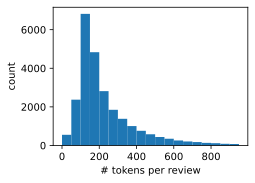

In [5]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

正如我们所料，评论的长度各不相同。为了每次处理一小批量这样的评论，我们通过阶段和填充将每个评论的长度设置为500.这类似于对机器翻译数据集的预处理步骤。

In [6]:
num_steps=500   #序列长度
train_features=torch.tensor([d2l.truncate_pad(
    vocab[line],num_steps,vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


## 1.3 创建数据迭代器

现在我们可以创建数据迭代器了。在每次迭代中，都会返回一小批量样本。

In [7]:
train_iter=d2l.load_array((train_features,torch.tensor(train_data[1])),64)
for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('小批量数目：', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
小批量数目： 391


## 1.4 整合代码

最后，我们将上述步骤封装到load_data_imdb函数中。它返回训练和测试数据迭代器以及IMDb评论数据集的词表。

In [8]:
#@save
def load_data_imdb(batch_size, num_steps=500):
    """返回数据迭代器和IMDb评论数据集的词表"""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb') #下载并解压IMDb评论数据集
    train_data = read_imdb(data_dir, True)  #读取训练集数据,并返回评论文本和情感标签。
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')    #分词
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5) #基于训练集词元构建词表，将词元映射到唯一的整数索引
    # 将训练集词元转换为对应的整数索引序列，并使用num_steps限制序列长度，过长则截断，过短则填充
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    #  创建训练集数据迭代器。将训练集的特征序列和情感标签打包成一个元组，并使用batch_size指定批量大小
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

# 二、情感分析：使用循环神经网络

与词相似度和类比任务一样，我们也可以将预先训练的词向量应用于情感分析。由于IMDb评论数据集不是很大，使用在大规模语料库上预训练的文本表示可以减少模型的过拟合。我们将使用预训练的GloVe模型来表示每个词元，并将这些词元表示送入多层双向循环神经网络以获得文本序列表示，该文本序列表示将被转换为情感分析输出。对于相同的下游应用，我们稍后将考虑不同的架构选择。

![](https://files.mdnice.com/user/23981/1afd6d19-35c7-4157-8cc9-ef16a2b555cb.png)

>GloVe（Global Vectors for Word Representation）是一种用于学习词向量表示的无监督算法。它通过对全局统计信息进行建模，旨在捕捉词语之间的语义和语法关系。
>下面是GloVe模型的详细介绍：
>1. **词共现矩阵构建**：GloVe模型首先构建一个词共现矩阵，该矩阵记录了在大规模语料库中两个词语共同出现的频次信息。共现矩阵是一个对称矩阵，其中每个元素表示两个词语在上下文中共现的次数。
>2. **损失函数设计**：GloVe模型的核心思想是通过最小化损失函数来学习词向量表示。损失函数基于词语之间的共现信息，并且被设计为能够表达词语之间的关联性。具体而言，GloVe模型使用了点积的形式来度量词向量之间的关系。
>3. **词向量学习**：GloVe模型通过梯度下降等优化算法来学习词向量表示。在训练过程中，模型调整词向量的参数以最小化损失函数。学习过程中，模型通过优化损失函数来提高词向量的质量，使得相似的词语在词向量空间中更加接近。
>4. **词向量应用**：训练完成后，GloVe模型得到每个词语的向量表示。这些向量可以应用于各种自然语言处理任务中，例如词语相似度计算、文本分类、情感分析等。通过将词语映射到低维向量空间，GloVe模型使得计算机能够理解和处理自然语言的语义关系。
>GloVe模型的优点是能够同时捕捉全局的统计信息和局部的上下文关系，提供了一种有效的词向量学习方法。相比于其他词向量模型如Word2Vec，GloVe模型在一些任务上表现出更好的性能。然而，GloVe模型也有一些限制，例如对于罕见词语的建模能力较弱，并且无法处理词语的多义性。

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## 2.1 使用循环神经网络表示单个文本

在文本分类任务（如情感分析）中，可变长度的文本序列将被转换为固定长度的类别。在下面的BiRNN类中，虽然文本序列的每个词元经由嵌入层（self.embedding）获得其单独的预训练GloVe表示，但是整个序列由双向循环神经网络（self.encoder）编码。更具体地说，双向长短期记忆网络在初始和最终时间步的隐状态（在最后一层）被连结起来作为文本序列的表示。然后，通过一个具有两个输出（“积极”和“消极”）的全连接层（self.decoder），将此单一文本表示转换为输出类别。

In [10]:
class BiRNN(nn.Module):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,**kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding=nn.Embedding(vocab_size,embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder=nn.LSTM(embed_size,num_hiddens,num_layers=num_layers,bidirectional=True)
        self.decoder=nn.Linear(4*num_hiddens,2)

    def forward(self,inputs):
        # inputs的形状是（批量大小，时间步数），因为LSTM网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置，输出形状为（时间步数，批量大小，词向量维度）
        embeddings=self.embedding(inputs.T)
        self.encoder.flatten_parameters()   #调用flatten_parameters方法，为了在处理可变长度序列时优化内存使用和性能
        # 返回上一个隐藏层在不同时间步的隐状态
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs,_=self.encoder(embeddings)
        # 连接初始和最终时间步的隐状态，作为全连接层的输入，其形状为（批量大小，4*隐藏单元数）
        encoding=torch.cat((outputs[0],outputs[-1]),dim=1)
        outs=self.decoder(encoding)
        return outs

让我们构造一个具有两个隐藏层的双向循环神经网络来表示单个文本以进行情感分析。

In [11]:
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names: ##m._flat_weights_names是LSTM层中所有参数的名称列表
            if "weight" in param:   #如果参数名称中包含"weight"，那么使用nn.init.xavier_uniform_函数对该参数进行初始化
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

## 2.2 加载预训练的词向量

下面，我们为词表中的单词加载预训练的100维（需要与embed_size一致）的GloVe嵌入。

In [12]:
glove_embedding=d2l.TokenEmbedding('glove.6b.100d')

打印词表中所有词元向量的形状

In [13]:
embeds=glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

我们使用这些与训练的词向量来表示评论中的词元，并且在训练期间不要更新这些向量。

In [14]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad=False

## 2.3 训练和评估模型

现在我们可以训练双向循环神经网络进行情感分析。

loss 0.298, train acc 0.875, test acc 0.857
145.3 examples/sec on [device(type='cuda', index=0)]


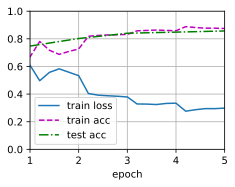

In [15]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

我们定义以下函数来使用训练好的模型net预测文本序列的情感。

In [16]:
#@save
def predict_sentiment(net, vocab, sequence):
    """预测文本序列的情感"""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [17]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [18]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## 三、情感分析：使用卷积神经网络

在 6节中，我们探讨了使用二维卷积神经网络处理二维图像数据的机制，并将其应用于局部特征，如相邻像素。虽然卷积神经网络最初是为计算机视觉设计的，但它也被广泛用于自然语言处理。简单地说，只要将任何文本序列想象成一维图像即可。通过这种方式，一维卷积神经网络可以处理文本中的局部特征，例如n元语法。

本节将使用textCNN模型来演示如何设计一个表示单个文本 (Kim, 2014)的卷积神经网络架构。与 图15.2.1中使用带有GloVe预训练的循环神经网络架构进行情感分析相比， 图15.3.1中唯一的区别在于架构的选择。

![](https://files.mdnice.com/user/23981/af9f3001-0dd4-4a7d-8435-db56c1fe66f3.png)

In [19]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## 3.1 一维卷积

在介绍该模型之前，让我们先看看一维卷积是如何工作的。请记住，这只是基于互相关运算的二维卷积的特例。

![](https://files.mdnice.com/user/23981/d55bfc17-8d3b-4097-8439-54757d764c5a.png)

如图15.3.2中所示，在一维情况下，卷积窗口在输入张量上从左向右滑动。在滑动期间，卷积窗口中某个位置包含的输入子张量（例如，图15.3.2中的0和1）和核张量（例如，图15.3.2中的1和2）
按元素相乘。这些乘法的总和在输出张量的相应位置给出单个标量值（例如，图15.3.2中的0x1+1x2=2）。
我们在下面的corrld函数中实现了一维互相关。给定输入张量X和核张量K，它返回输出张量Y。

In [20]:
def corr1d(X,K):
    w=K.shape[0]
    Y=torch.zeros((X.shape[0]-2+1))
    for i in range(Y.shape[0]):
        Y[i]=(X[i:i+w]*K).sum()
    return Y

我们可以从 图15.3.2构造输入张量X和核张量K来验证上述一维互相关实现的输出。

In [21]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

对于任何具有多个通道的一维输入，卷积核需要具有相同数量的输入通道。然后，对于每个通道，对输入的一维张量和卷积核的一维张量执行互相关运算，将所有通道上的结果相加以产生一维输出张量。下图演示了具有3个输入通道的一维互相关操作。

![](https://files.mdnice.com/user/23981/98164e3c-5841-497a-aaf0-e6bdafd63a7f.png)

我们可以实现多个输入通道的一维互相关运算，并在 图15.3.3中验证结果。

In [22]:
def corr1d_multi_in(X, K):
    # 首先，遍历'X'和'K'的第0维（通道维）。然后，把它们加在一起
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

注意，多输入通道的一维互相关等同于单输入通道的二维互相关。举例说明， 图15.3.3中的多输入通道一维互相关的等价形式是 图15.3.4中的单输入通道二维互相关，其中卷积核的高度必须与输入张量的高度相同。

![](https://files.mdnice.com/user/23981/4ba32cba-b520-4056-84bb-6f57f428bf96.png)

图15.3.2和 图15.3.3中的输出都只有一个通道。与 subsec_multi-output-channels中描述的具有多个输出通道的二维卷积相同，我们也可以为一维卷积指定多个输出通道。

## 3.2 最大时间汇聚层

类似的，我们可以使用汇聚层从序列表示中提取最大值，作为跨时间步的最重要特征。textCNN中使用的最大时间汇聚层的工作原理类似于一维全局汇聚。对于每个通道在不同时间步存储的多通道输入，每个通道的输出是该通道的最大值。请注意，最大时间汇聚允许在不同通道上使用不同数量的时间步。

## 3.3 textCNN模型

使用一维卷积和最大时间汇聚，textCNN模型将单个预训练的词元表示作为输入，然后获得并转换用于下游应用的序列表示。

对于具有由d维向量表示的n个词元的单个文本序列，输入张量的宽度、高度和通道数分别为n、1、d。textCNN模型将输入转换作为输出，如下所示：

1. 定义多个一维卷积核，并分别对输入执行卷积运算。具有不同宽度的卷积核可以捕捉不同数量的相邻词元之间的局部特征
2. 在所有输出通道上执行最大时间汇聚层，然后将所有标量汇聚输出联结为向量。
3. 使用全连接层将连结后的向量转换为输出类别。Dropout可以用来减少过拟合。

![](https://files.mdnice.com/user/23981/9f5fdb29-8400-4854-bae8-849afd2990fd.png)

图15.3.5通过一个具体的例子说明了textCNN的模型架构。输入是具有11个词元的句子，其中每个词元由6维向量表示。因此，我们有一个宽度为11的6通道输入。定义两个宽度为2和4的一维卷积核，分别具有4个和5个输出通道。它们产生4个宽度为11-2+1= 10的输出通道和5个宽度为11-4+1=8的输出通道。尽管这9个通道的宽度不同，但最大时间汇聚层给出了一个连结的9维向量，该向量最终被转换为用于二元情感预测的2维输出向量。

### 3.3.1 定义模型

我们在下面的类中实现textCNN模型。与 15.2节的双向循环神经网络模型相比，除了用卷积层代替循环神经网络层外，我们还使用了两个嵌入层：一个是可训练权重，另一个是固定权重。

In [27]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 最大时间汇聚层没有参数，因此可以共享此实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        embeddings = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

#### nn.AdaptiveAvgPool1d(1)

在PyTorch中，`nn.AdaptiveAvgPool1d(1)`是一个用于自适应平均池化的层级。具体来说，它将输入张量的每个通道沿着时间维度进行平均池化，以生成输出张量。

这个层级可以将任意形状的1D张量转换成形状为 `(batch_size, num_channels, 1)` 的张量，其中 `num_channels` 表示输入张量中的通道数。因为它只对时间维度进行池化操作，因此无论输入张量的长度是多少，输出的维度始终是1。

一些常见的使用情况包括将变长的时间序列数据变成固定大小的表示，或者将1D卷积神经网络的输出转换成密集的特征向量，以便后续分类任务。

#### "最大时间汇聚层没有参数，因此可以共享此实例"

这里应该是平均汇聚层。

在神经网络中，通常需要多次使用相同的层或模块。如果每次都要重新声明这些层或模块，会增加代码的冗余，也会占用更多的内存。

为了解决这个问题，PyTorch提供了一种共享模块/层实例的方式。这意味着，可以将一个模块/层实例作为单个对象创建，并在需要使用该模块/层的地方重复使用它，而不是每次重新声明它。

在这里，注释中提到的“共享此实例”，是指 `nn.AdaptiveAvgPool1d(1)` 这个层只需在类构造函数中声明一次，然后可以在不同的方法中重复使用它，而不必再次声明它。这样做可以减少代码的重复性和内存开销。同样地，`nn.ReLU()` 也可以被共享。

让我们创建一个textCNN实例。它有3个卷积层，卷积核宽度分别为3、4和5，均有100个输出通道。

In [28]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

TextCNN(
  (embedding): Embedding(49346, 100)
  (constant_embedding): Embedding(49346, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

#### net.apply(init_weights)

在`net.apply(init_weights)`这行代码中，`init_weights`函数被应用于`net`模型的所有子模块。

当调用`apply`方法时，它会递归地遍历`net`模型的所有子模块，并对每个子模块调用`init_weights`函数。在调用`init_weights`函数时，每个子模块会作为参数`m`传递给函数。

因此，在`init_weights`函数中，`m`表示当前遍历到的子模块。通过检查`m`的类型，可以确定当前子模块是线性层(`nn.Linear`)还是一维卷积层(`nn.Conv1d`)。根据子模块的类型，可以对其权重进行初始化操作。

总结起来，`net.apply(init_weights)`的作用是对`net`模型的所有线性层和一维卷积层的权重进行Xavier均匀初始化。

### 3.3.2、加载预训练词向量

与 15.2节相同，我们加载预训练的100维GloVe嵌入作为初始化的词元表示。这些词元表示（嵌入权重）在embedding中将被训练，在constant_embedding中将被固定。


In [29]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

### 3.3.3 训练和评估模型

现在我们可以训练textCNN模型进行情感分析。

loss 0.063, train acc 0.980, test acc 0.870
195.5 examples/sec on [device(type='cuda', index=0)]


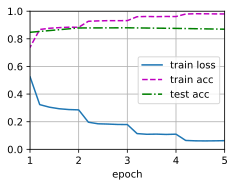

In [30]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

下面，我们使用训练好的模型来预测两个简单句子的情感。

In [31]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [32]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'